# Tokyo weather analysis

In [120]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

In [121]:
# read processed before dataset
df = pd.read_csv("Tokyo.csv", index_col=0)
df.set_index([pd.to_datetime(df.index)], inplace=True)

In [122]:
df

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
1990-01-01,43.300000,19.657143,1016.614286,999.900000,18.200000,7.571429,0.000000
1990-01-08,44.028571,26.328571,1018.385714,999.900000,7.828571,6.457143,0.022857
1990-01-15,39.128571,26.485714,1018.385714,999.900000,6.300000,6.057143,14.405714
1990-01-22,38.071429,15.614286,1021.585714,999.900000,13.857143,7.000000,0.000000
1990-02-01,39.328571,30.285714,1026.857143,999.900000,4.142857,6.342857,0.202857
...,...,...,...,...,...,...,...
2019-10-22,63.100000,57.171429,1015.171429,12.314286,12.671429,5.328571,1.098571
2019-11-01,59.800000,47.314286,1015.171429,12.285714,14.000000,4.357143,0.064286
2019-11-08,57.628571,44.571429,1014.128571,11.228571,14.042857,4.885714,0.040000
2019-11-15,57.375000,44.825000,1016.825000,13.925000,14.850000,5.625000,0.000000


Our weather data contains measures of temperature, dew point, sea level pressure, station pressure, visibility, wind speed and precipitation amount. Here I will analyse each of this measurment.

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose time series data to trend, season and residuals
def decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    residual.dropna(inplace=True);
    
    # Original
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    
    # Trend
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    # Seasonality
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    # Resudials
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    return residual

## Temperature

In [58]:
temp = df.TEMP
temp

1990-01-01    43.300000
1990-01-08    44.028571
1990-01-15    39.128571
1990-01-22    38.071429
1990-02-01    39.328571
                ...    
2019-10-22    63.100000
2019-11-01    59.800000
2019-11-08    57.628571
2019-11-15    57.375000
2019-11-22    52.824330
Name: TEMP, Length: 1436, dtype: float64


To predict weather data for 2019 year, we will use ARIMA model.To do that we need to decompose data to make our time series data stationary - extract trend and season from it.


__Decomposing__

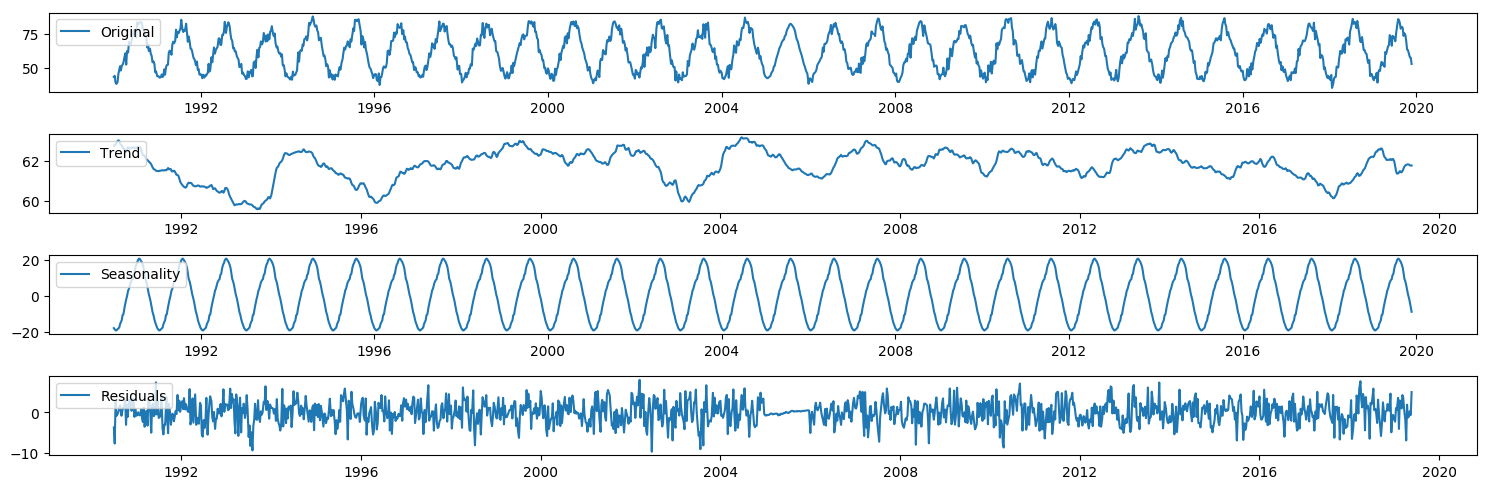

In [59]:
# 48, cause there are 4 weeks for each month, and there are 12 month, so period should be 4*12 = 48
temp_res = decompose(temp, 48)

In [60]:
temp_res

1990-07-01   -3.722631
1990-07-08   -7.715515
1990-07-15    2.721054
1990-07-22   -0.906616
1990-08-01   -0.411290
                ...   
2019-04-22   -1.296419
2019-05-01   -1.019162
2019-05-08    0.277425
2019-05-15   -0.651083
2019-05-22    4.989112
Name: TEMP, Length: 1388, dtype: float64

Now, lets check stationarity of our residuals. To do that, I'll use ADF test. To be 99% confident, that ts is stationary, ADF statistic should be less than critical value of 1%. Also we can check stationarity be p-value - it should be less than 0.01.

In [61]:
from statsmodels.tsa.stattools import adfuller

def df_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [62]:
df_test(temp_res)

ADF Statistic: -12.704920
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


__Selecting parameters of the model__

As we can see, our residuals are stationary, do now we can use ARIMA. ARIMA has 3 parameters: __p, d and  q__. __d__ responds for differencing level(another way to make ts stationary), but, as we already did our data stationary, we can set d=0 to not difference our ts one more time. Now, lets find p and q.

To find p I'll use partial autocorrelation function (PACF), and to find q - autocorrelation function (ACF). We need to take first biggest lag, which is above significance line. 

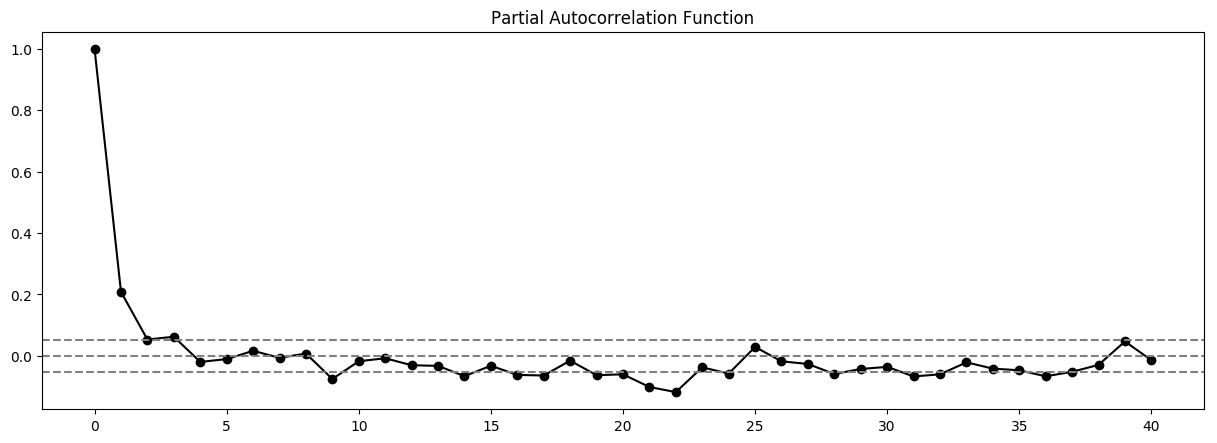

In [83]:
from statsmodels.tsa.stattools import acf, pacf

lag_pacf = pacf(temp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, here first biggest lag above signifacance line is 1, so __p=1__.

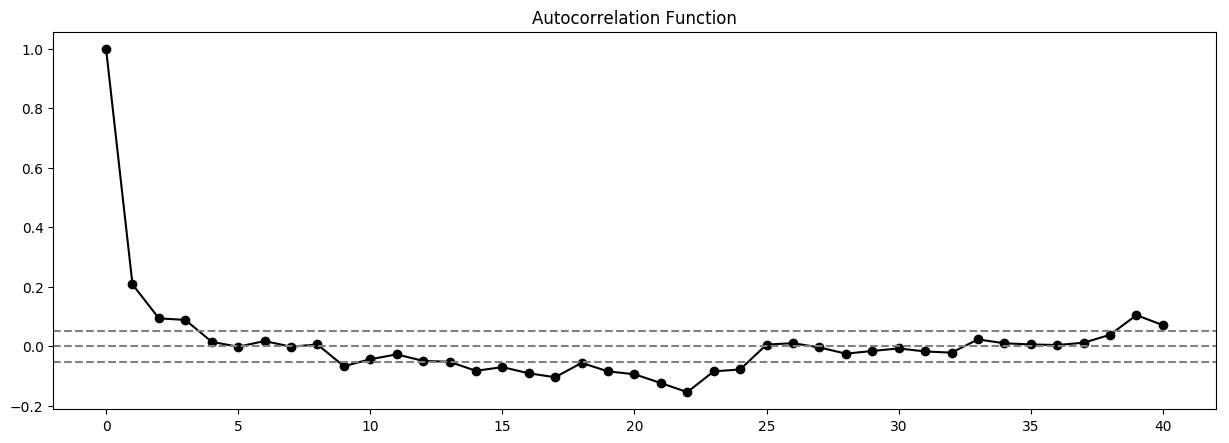

In [84]:
lag_acf = acf(temp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here, __q=3__

__Fitting model and predicting__

In [73]:
temp_model = ARIMA(temp_res, order=(1, 0, 3))
temp_model_fit = temp_model.fit(disp=-1)

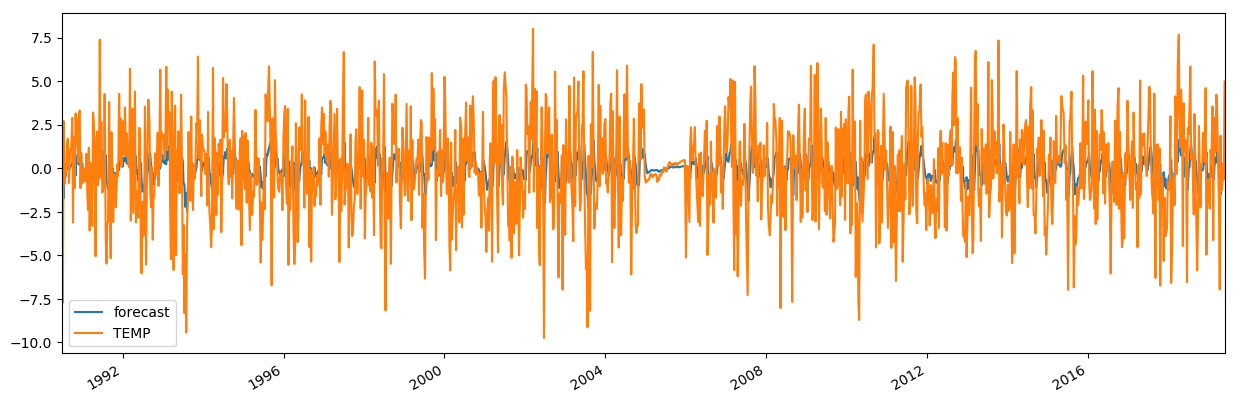

In [74]:
# Actual vs Fitted
temp_model_fit.plot_predict(dynamic=False)
plt.show()

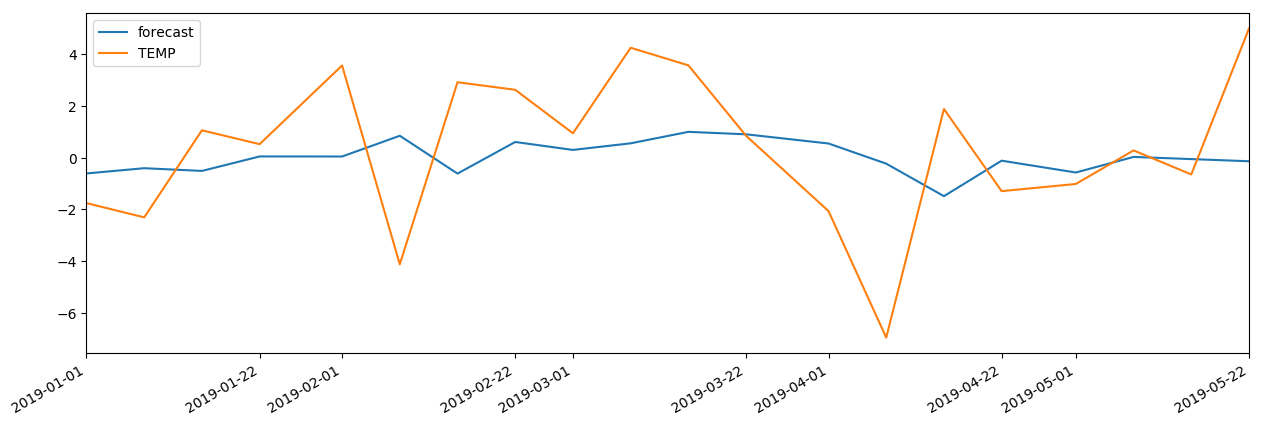

In [75]:
# only 2019 year
temp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Dew point

In [78]:
dewp = df.DEWP
dewp

1990-01-01    19.657143
1990-01-08    26.328571
1990-01-15    26.485714
1990-01-22    15.614286
1990-02-01    30.285714
                ...    
2019-10-22    57.171429
2019-11-01    47.314286
2019-11-08    44.571429
2019-11-15    44.825000
2019-11-22    37.833955
Name: DEWP, Length: 1436, dtype: float64

__Decomposing__

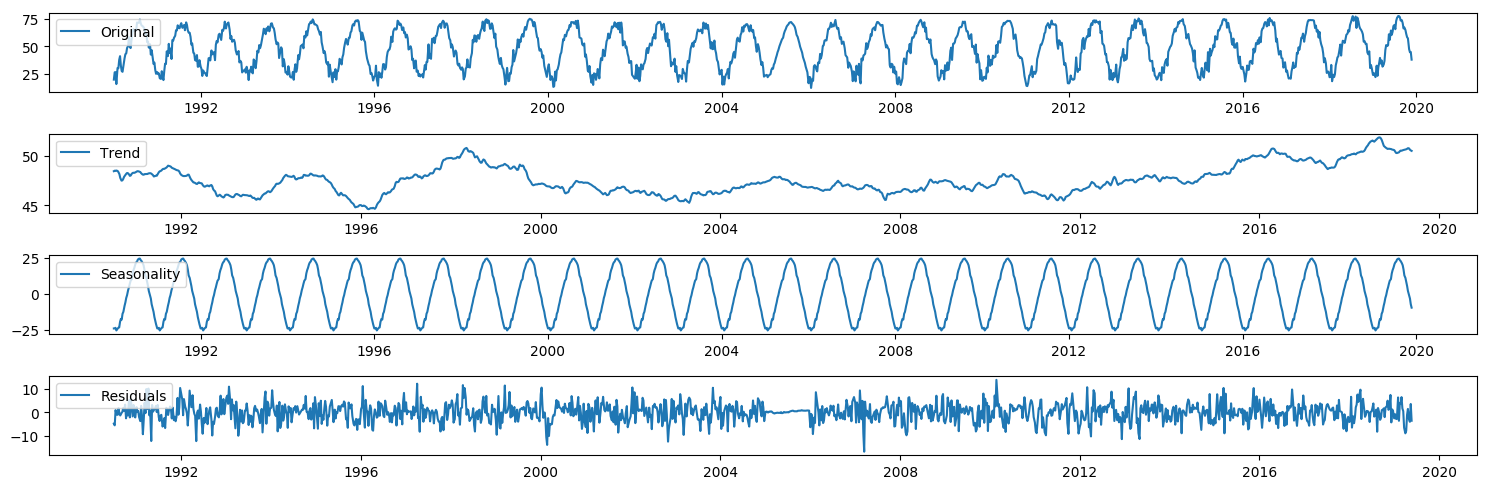

In [79]:
dewp_res = decompose(dewp, 48)

In [80]:
dewp_res

1990-07-01   -4.802345
1990-07-08   -5.538701
1990-07-15    0.940746
1990-07-22   -0.896619
1990-08-01   -1.092053
                ...   
2019-04-22    1.414535
2019-05-01   -2.968849
2019-05-08   -4.043430
2019-05-15    3.507872
2019-05-22   -3.583887
Name: DEWP, Length: 1388, dtype: float64

In [81]:
df_test(dewp_res)

ADF Statistic: -12.237285
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Residuals for dew point is stationary now, so we can select parameters for model.

__Selecting parameters of the model__

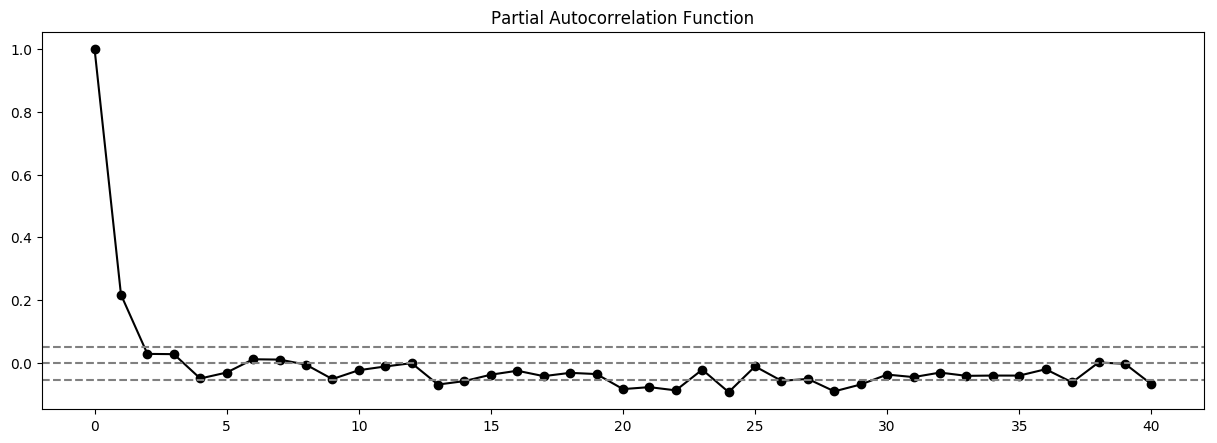

In [82]:
lag_pacf = pacf(dewp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, __p=1__.

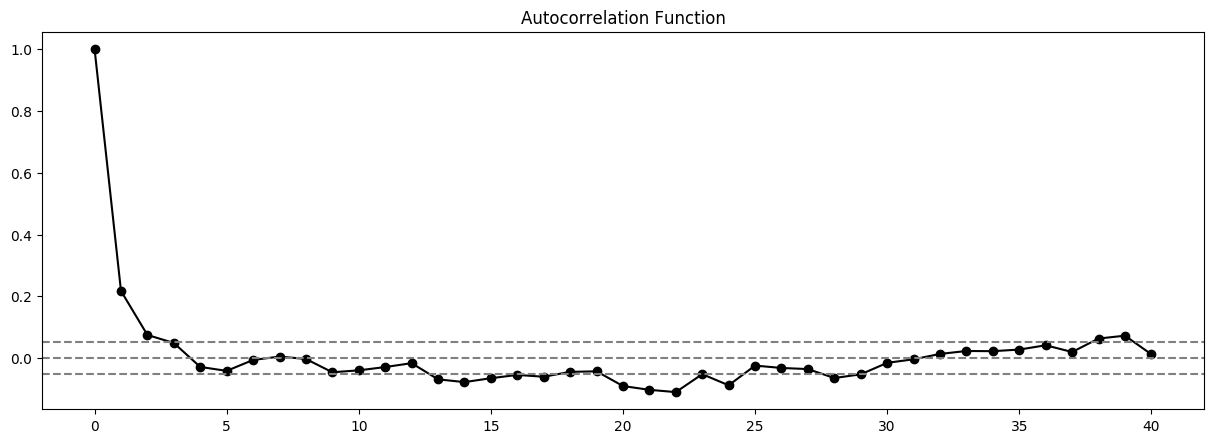

In [85]:
lag_acf = acf(dewp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=2__

__Fitting model and predicting__

In [86]:
dewp_model = ARIMA(dewp_res, order=(1, 0, 2))
dewp_model_fit = dewp_model.fit(disp=-1)

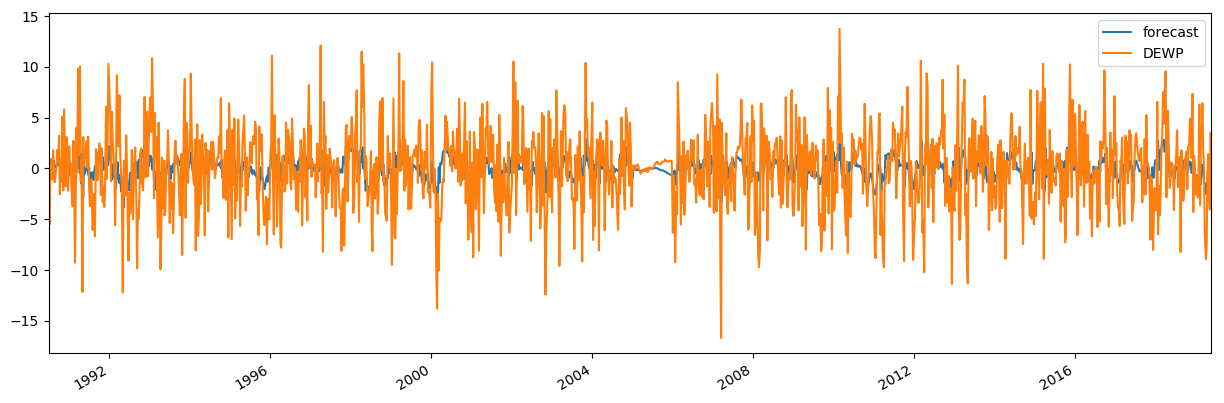

In [87]:
# Actual vs Fitted
dewp_model_fit.plot_predict(dynamic=False)
plt.show()

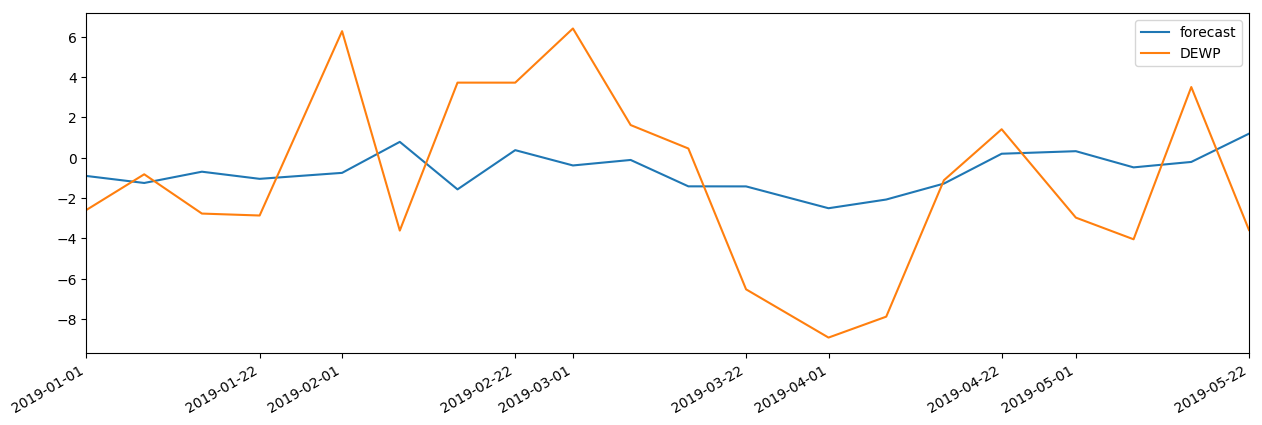

In [89]:
# only 2019 year
dewp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Sea level pressure

In [90]:
slp = df.SLP
slp

1990-01-01    1016.614286
1990-01-08    1018.385714
1990-01-15    1018.385714
1990-01-22    1021.585714
1990-02-01    1026.857143
                 ...     
2019-10-22    1015.171429
2019-11-01    1015.171429
2019-11-08    1014.128571
2019-11-15    1016.825000
2019-11-22    1018.876659
Name: SLP, Length: 1436, dtype: float64

__Decomposing__

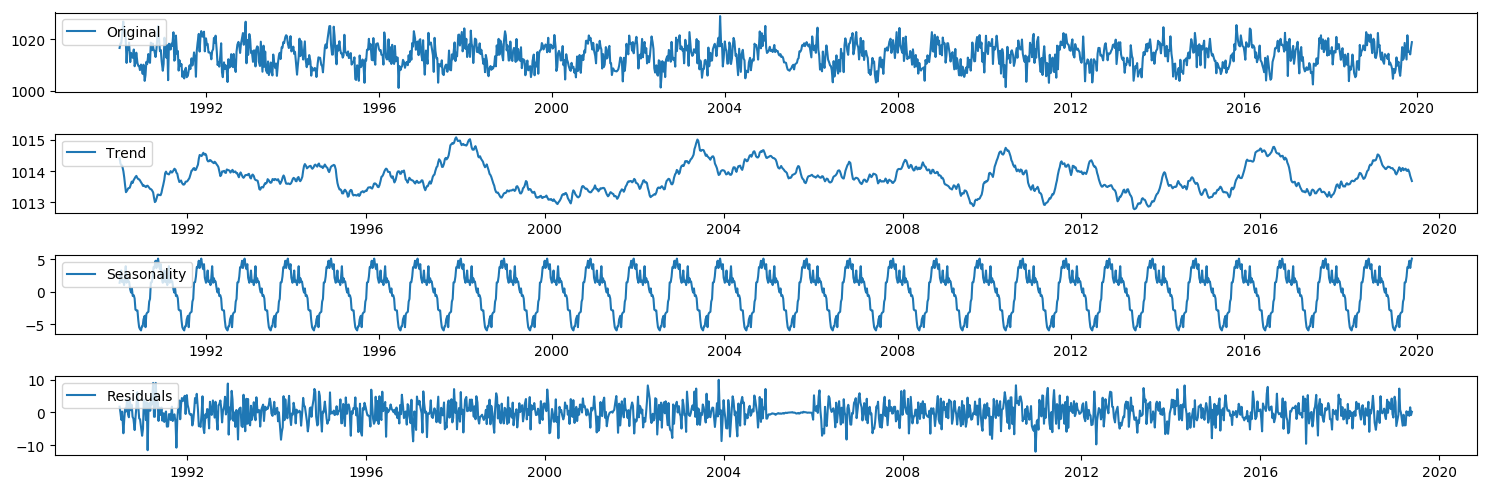

In [91]:
slp_res = decompose(slp, 48)

In [92]:
slp_res

1990-07-01    1.754956
1990-07-08   -0.049486
1990-07-15   -2.272656
1990-07-22    0.235656
1990-08-01   -6.387817
                ...   
2019-04-22    0.191228
2019-05-01   -1.058860
2019-05-08    1.561055
2019-05-15   -0.834025
2019-05-22    0.175722
Name: SLP, Length: 1388, dtype: float64

In [93]:
df_test(slp_res)

ADF Statistic: -11.676113
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Data for sea level pressure is stationaty, we can do further calculation

__Selecting parameters of the model__

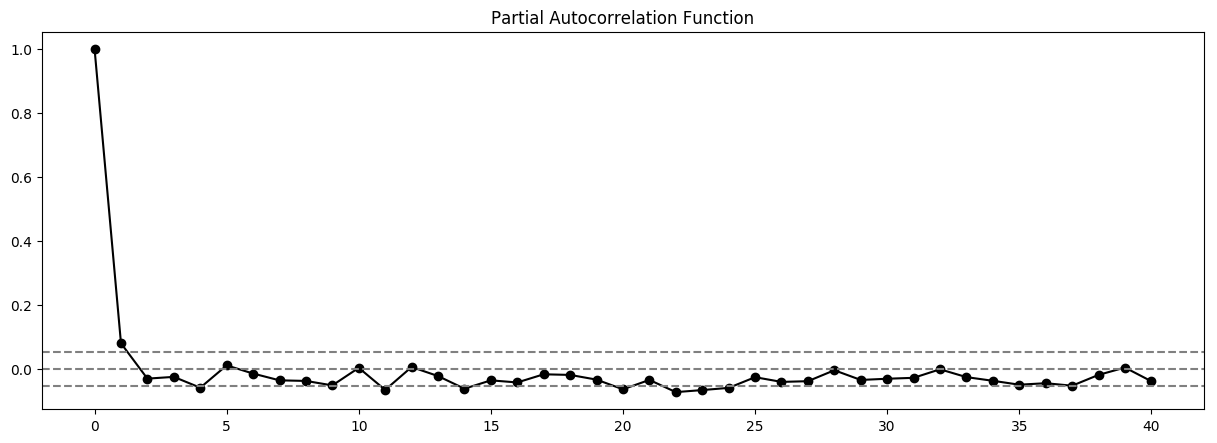

In [94]:
lag_pacf = pacf(slp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

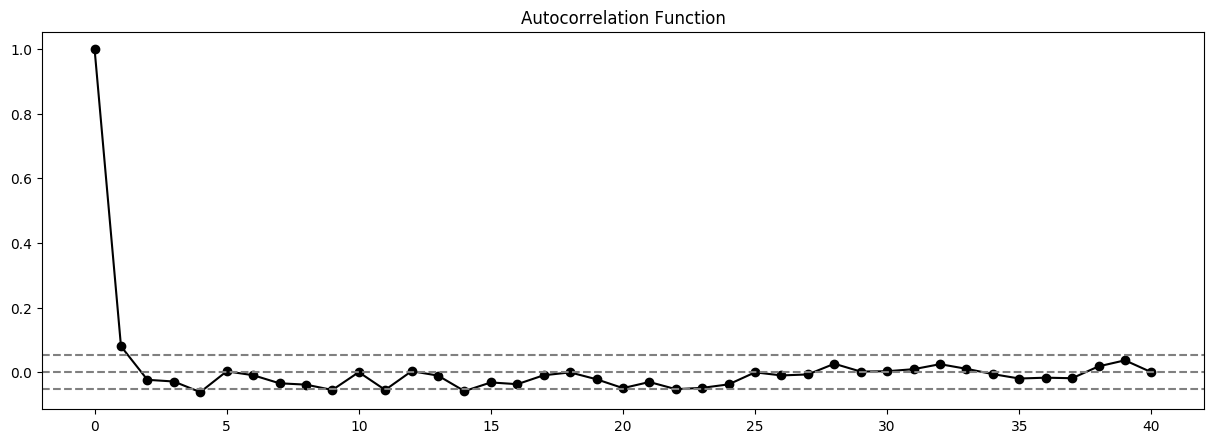

In [95]:
lag_acf = acf(slp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [96]:
slp_model = ARIMA(slp_res, order=(1, 0, 1))
slp_model_fit = slp_model.fit(disp=-1)

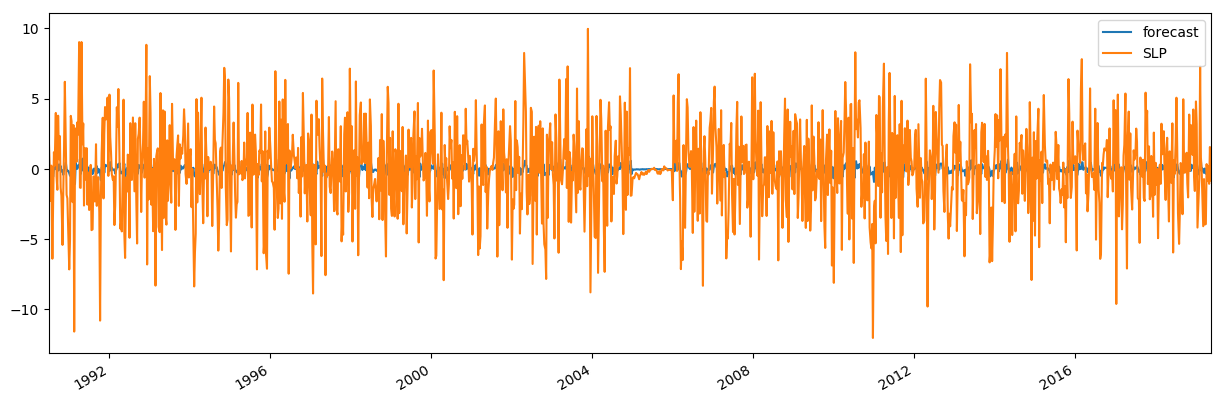

In [97]:
# Actual vs Fitted
slp_model_fit.plot_predict(dynamic=False)
plt.show()

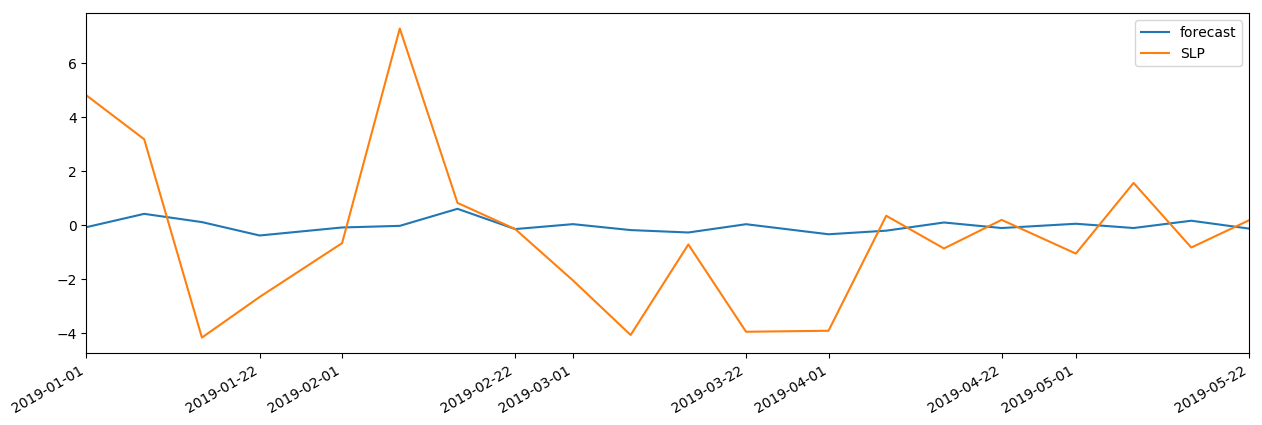

In [98]:
# only 2019 year
slp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Station pressure

In [99]:
stp = df.STP
stp

1990-01-01    999.900000
1990-01-08    999.900000
1990-01-15    999.900000
1990-01-22    999.900000
1990-02-01    999.900000
                 ...    
2019-10-22     12.314286
2019-11-01     12.285714
2019-11-08     11.228571
2019-11-15     13.925000
2019-11-22     64.991804
Name: STP, Length: 1436, dtype: float64

__Decomposing__

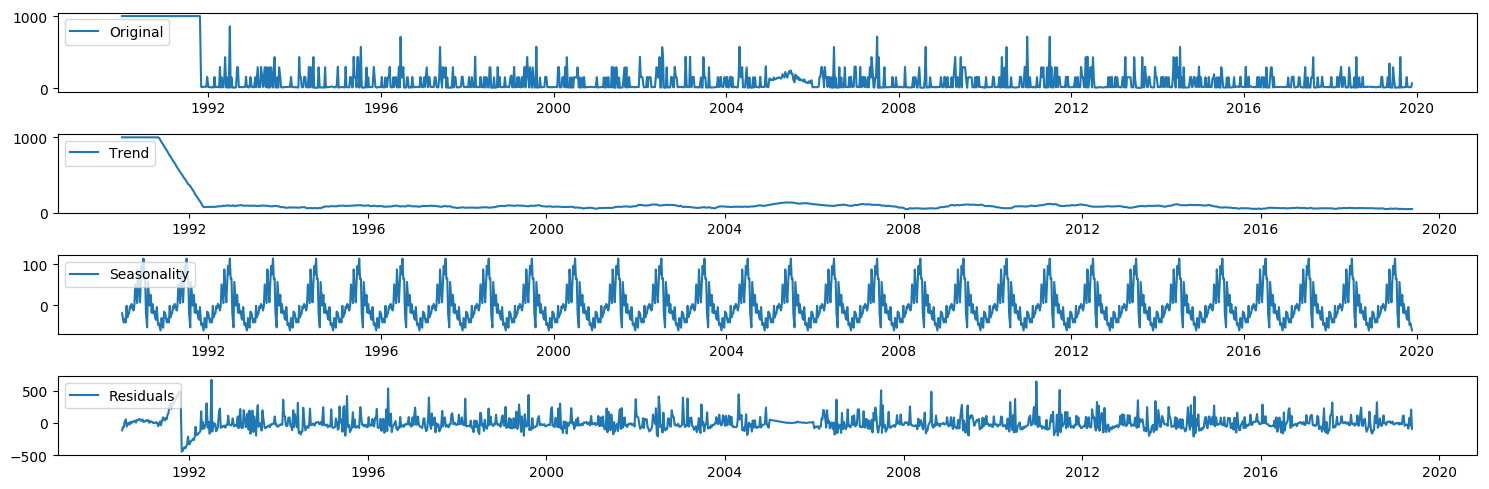

In [100]:
stp_res = decompose(stp, 48)

In [101]:
stp_res

1990-07-01   -114.108146
1990-07-08    -64.407298
1990-07-15    -65.208849
1990-07-22     19.652755
1990-08-01     53.869810
                 ...    
2019-04-22    -88.296133
2019-05-01     79.217963
2019-05-08    -41.340232
2019-05-15    205.505520
2019-05-22    -90.575698
Name: STP, Length: 1388, dtype: float64

In [102]:
df_test(stp_res)

ADF Statistic: -10.992553
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Data is stationary

__Selecting parameters of the model__

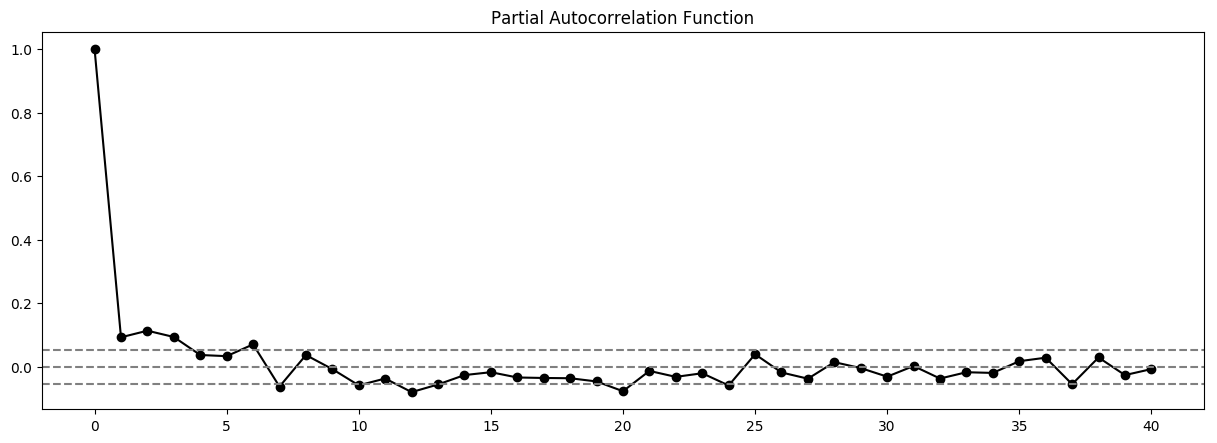

In [103]:
lag_pacf = pacf(stp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=3__

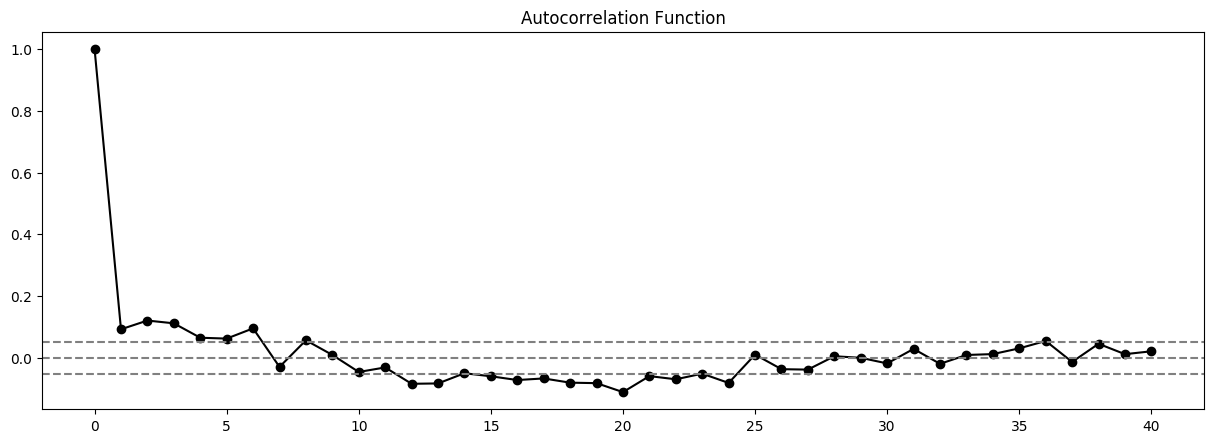

In [104]:
lag_acf = acf(stp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here looks like q can be 6, but it is better to take __q=3__.

__Fitting model and predicting__

In [108]:
stp_model = ARIMA(stp_res, order=(3, 0, 3))
stp_model_fit = stp_model.fit(disp=-1)

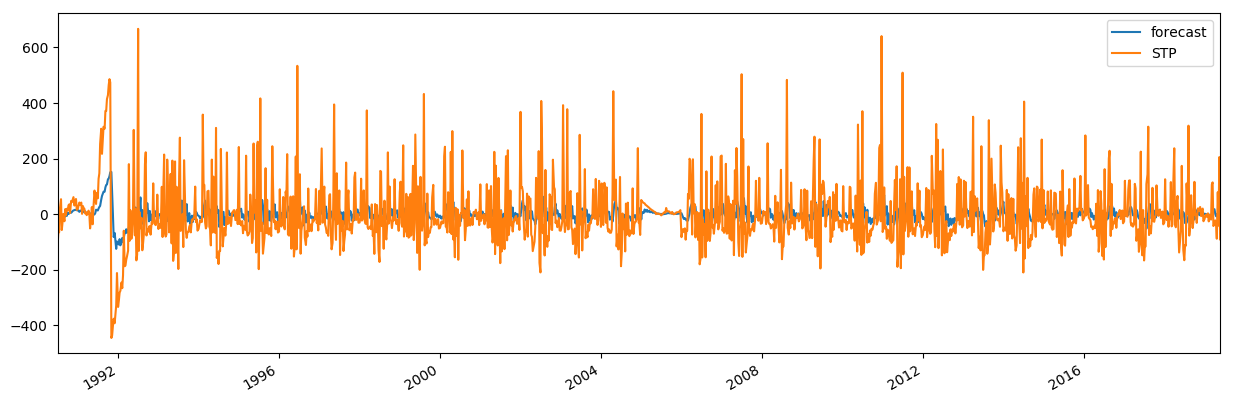

In [109]:
# Actual vs Fitted
stp_model_fit.plot_predict(dynamic=False)
plt.show()

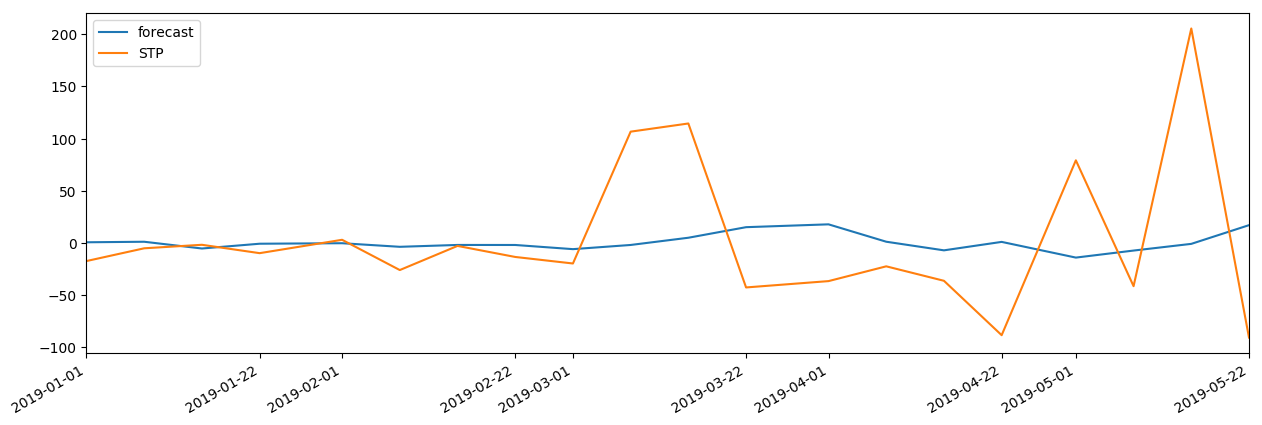

In [110]:
# only 2019 year
stp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Visibility

In [124]:
visib = df.VISIB
visib

1990-01-01    18.200000
1990-01-08     7.828571
1990-01-15     6.300000
1990-01-22    13.857143
1990-02-01     4.142857
                ...    
2019-10-22    12.671429
2019-11-01    14.000000
2019-11-08    14.042857
2019-11-15    14.850000
2019-11-22    10.061723
Name: VISIB, Length: 1436, dtype: float64

__Decomposing__

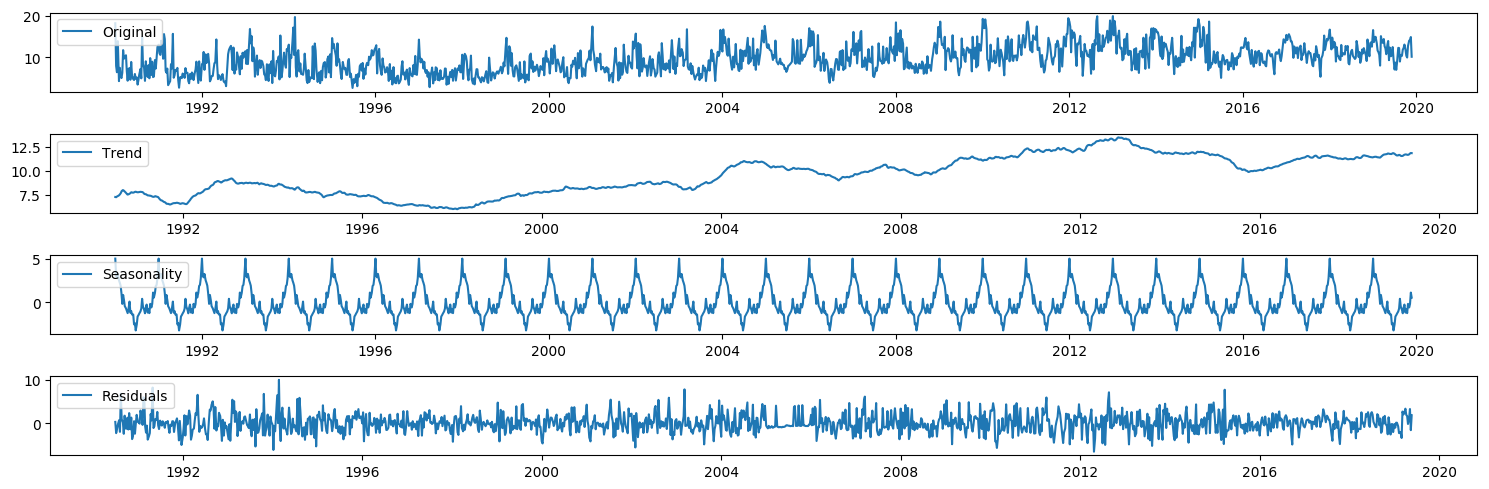

In [125]:
visib_res = decompose(visib, 48)

In [126]:
visib_res

1990-07-01    0.273744
1990-07-08   -2.332610
1990-07-15   -1.463046
1990-07-22   -0.341831
1990-08-01    0.669984
                ...   
2019-04-22   -0.203966
2019-05-01    1.094813
2019-05-08    3.259784
2019-05-15   -1.640940
2019-05-22    1.821432
Name: VISIB, Length: 1388, dtype: float64

In [127]:
df_test(visib_res)

ADF Statistic: -11.293155
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Visibility data is stationary

__Selecting parameters of the model__

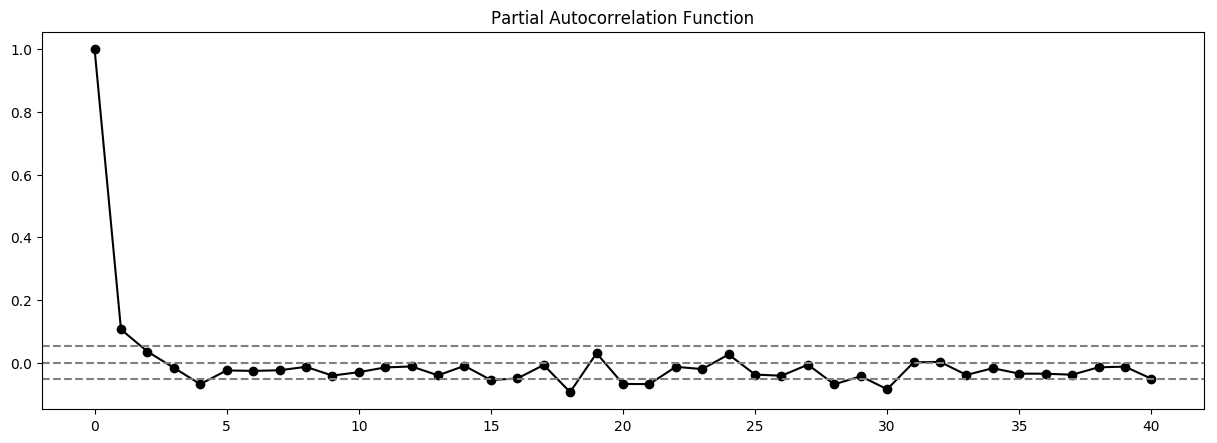

In [128]:
lag_pacf = pacf(visib_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

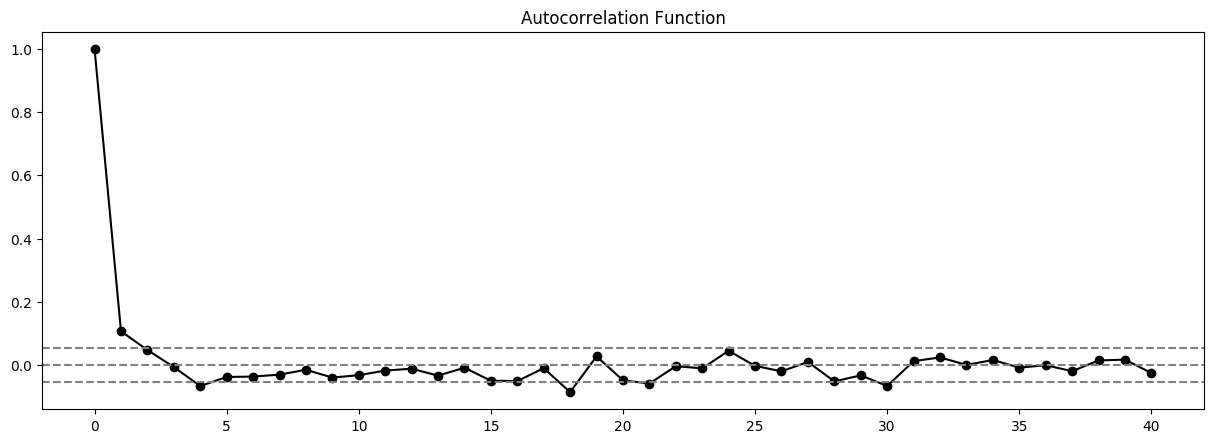

In [129]:
lag_acf = acf(visib_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [130]:
visib_model = ARIMA(visib_res, order=(1, 0, 1))
visib_model_fit = visib_model.fit(disp=-1)

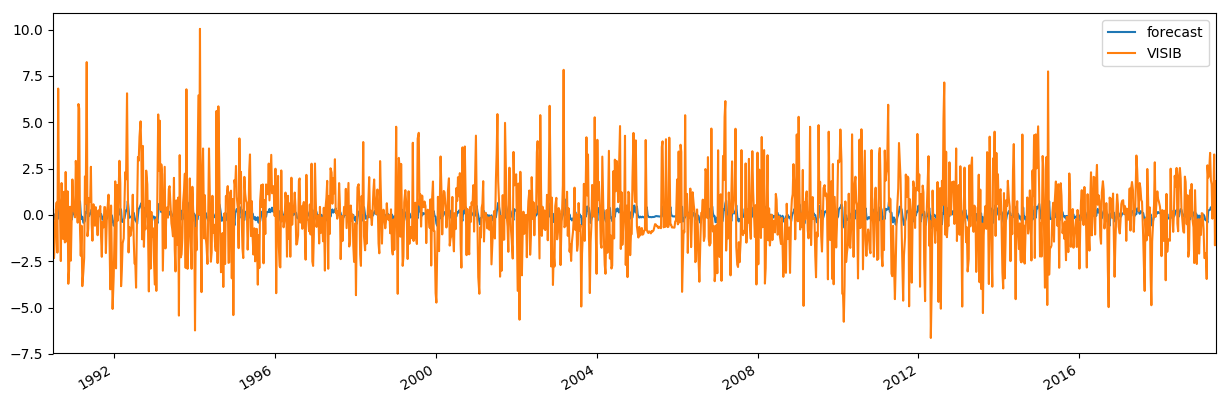

In [131]:
# Actual vs Fitted
visib_model_fit.plot_predict(dynamic=False)
plt.show()

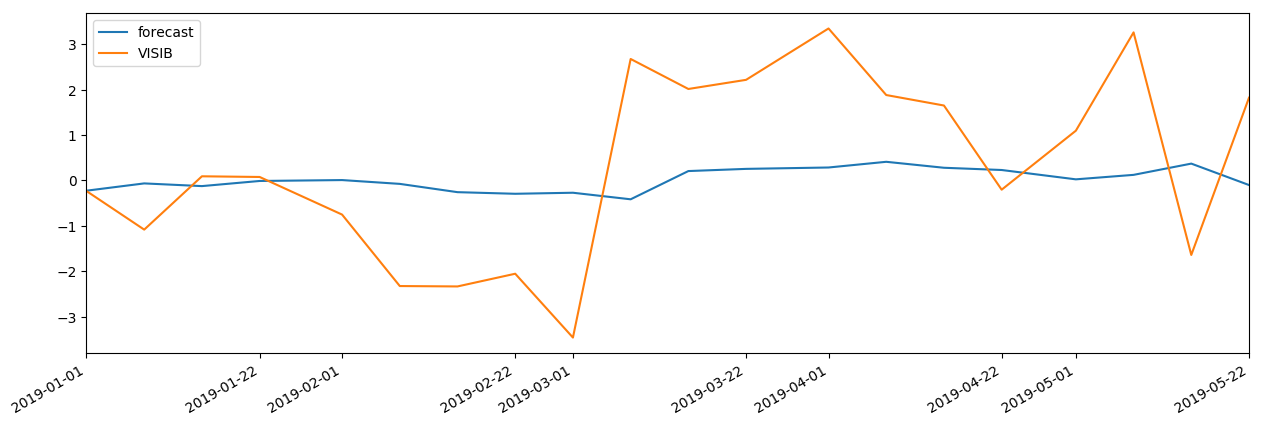

In [132]:
# only 2019 year
visib_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Wind speed

In [133]:
wdsp = df.WDSP
wdsp

1990-01-01    7.571429
1990-01-08    6.457143
1990-01-15    6.057143
1990-01-22    7.000000
1990-02-01    6.342857
                ...   
2019-10-22    5.328571
2019-11-01    4.357143
2019-11-08    4.885714
2019-11-15    5.625000
2019-11-22    5.527658
Name: WDSP, Length: 1436, dtype: float64

__Decomposition__

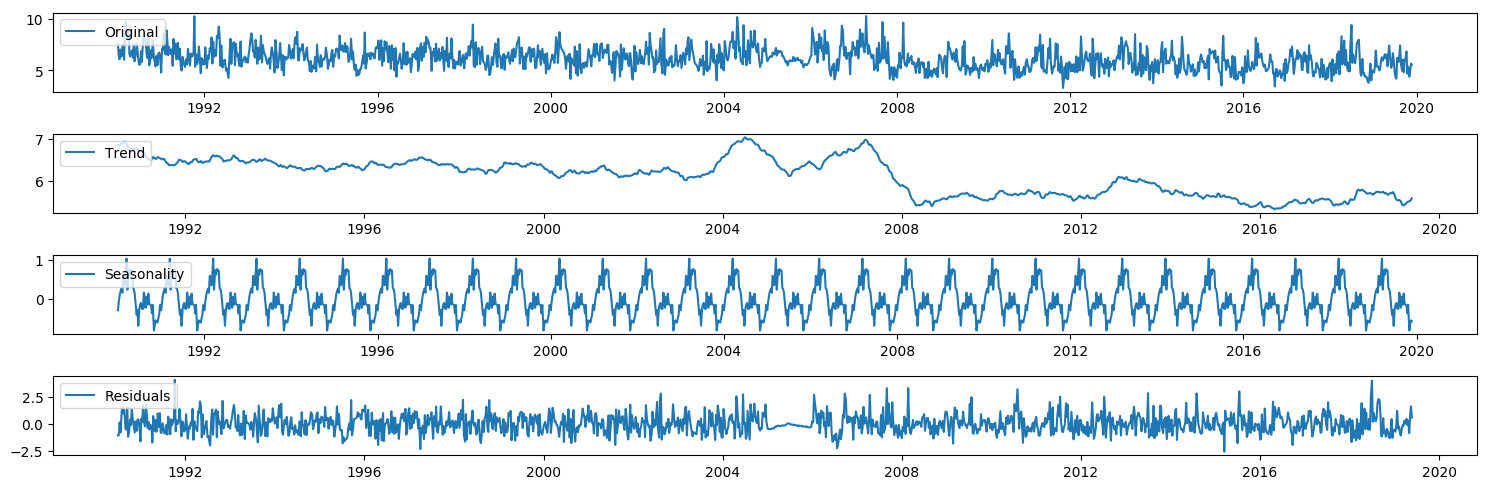

In [134]:
wdsp_res = decompose(wdsp, 48)

In [135]:
wdsp_res

1990-07-01   -1.097447
1990-07-08   -1.066783
1990-07-15    0.108074
1990-07-22   -0.815365
1990-08-01    1.127330
                ...   
2019-04-22    0.272197
2019-05-01   -0.880184
2019-05-08    0.680221
2019-05-15    1.595430
2019-05-22    0.563096
Name: WDSP, Length: 1388, dtype: float64

In [136]:
df_test(wdsp_res)

ADF Statistic: -11.763275
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Wind speed data is stationary now

__Selecting parameters of the model__

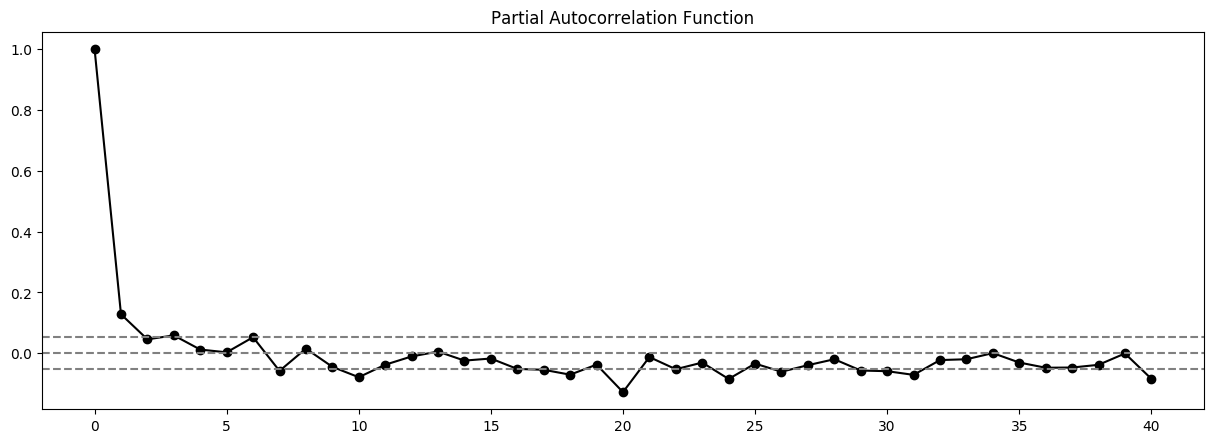

In [137]:
lag_pacf = pacf(wdsp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

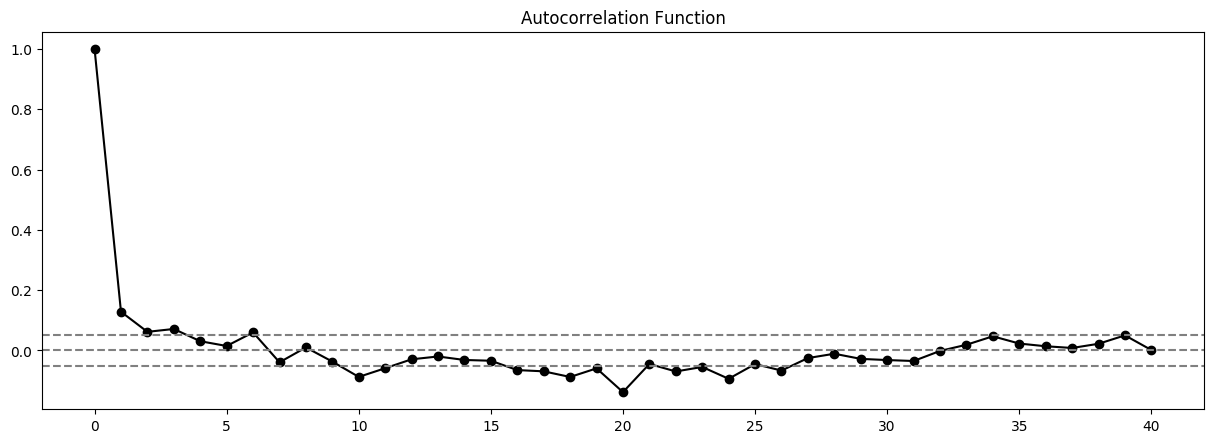

In [138]:
lag_acf = acf(wdsp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here we can not take q=3, so q=1 is an optimal one

__Fitting model and predicting__

In [141]:
wdsp_model = ARIMA(wdsp_res, order=(1, 0, 1))
wdsp_model_fit = wdsp_model.fit(disp=-1)

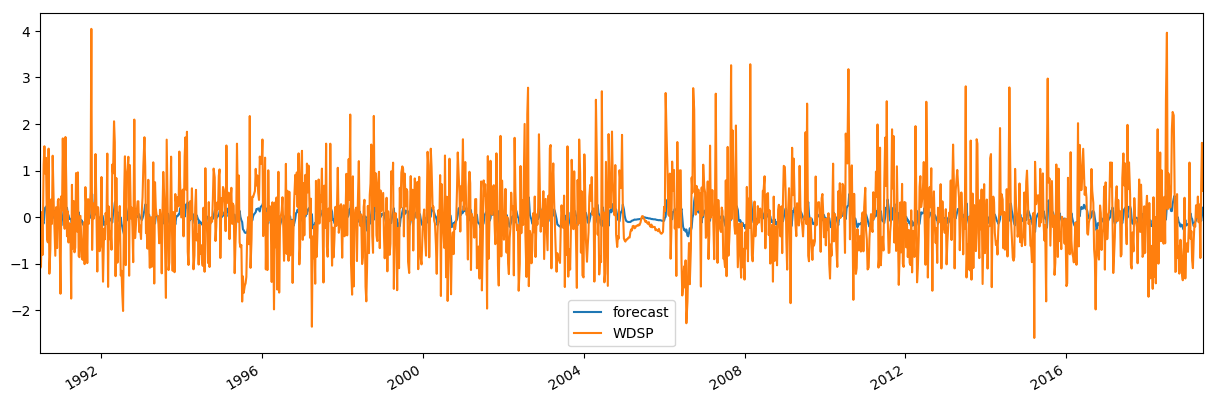

In [142]:
# Actual vs Fitted
wdsp_model_fit.plot_predict(dynamic=False)
plt.show()

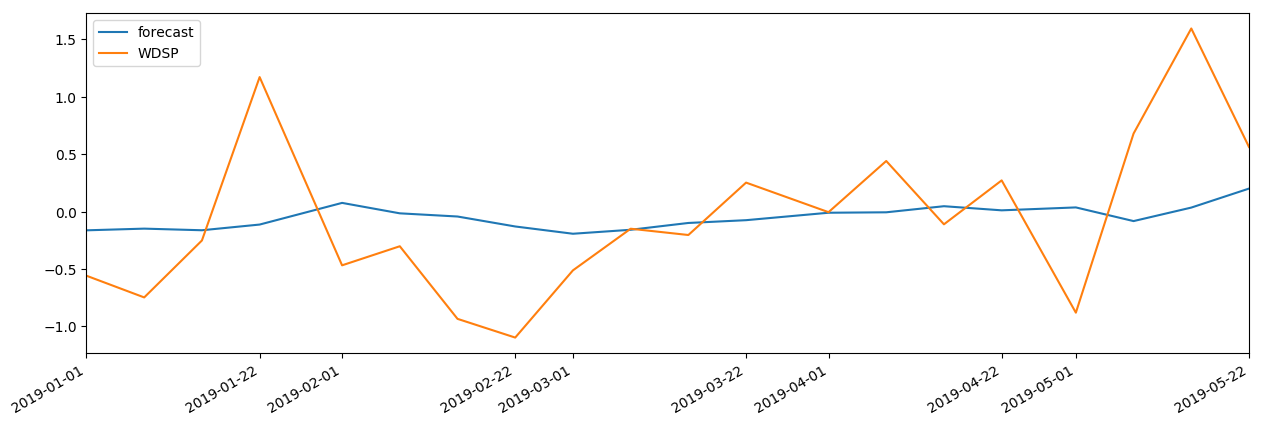

In [143]:
# only 2019 year
wdsp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Precipitation amount

In [144]:
prcp = df.PRCP
prcp

1990-01-01     0.000000
1990-01-08     0.022857
1990-01-15    14.405714
1990-01-22     0.000000
1990-02-01     0.202857
                ...    
2019-10-22     1.098571
2019-11-01     0.064286
2019-11-08     0.040000
2019-11-15     0.000000
2019-11-22     1.651843
Name: PRCP, Length: 1436, dtype: float64

__Decomposition__

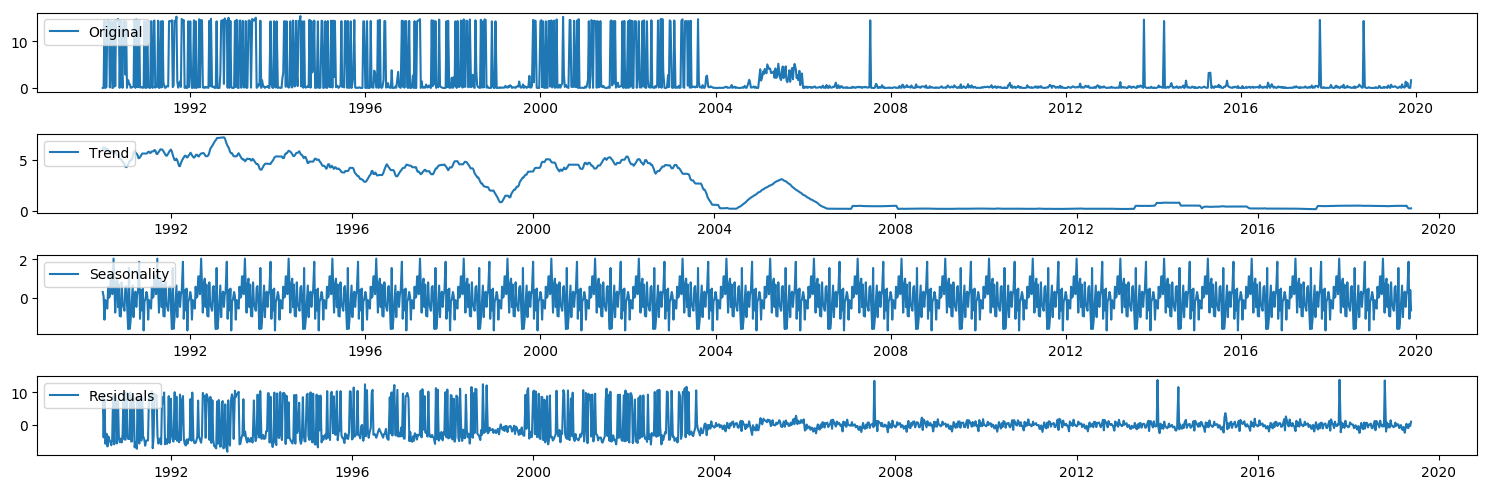

In [145]:
prcp_res = decompose(prcp, 48)

In [146]:
prcp_res

1990-07-01    8.943345
1990-07-08   -3.899400
1990-07-15    7.467269
1990-07-22   -5.812232
1990-08-01   -2.773451
                ...   
2019-04-22   -0.900183
2019-05-01   -0.982572
2019-05-08    0.274008
2019-05-15   -0.360566
2019-05-22    0.941108
Name: PRCP, Length: 1388, dtype: float64

In [147]:
df_test(prcp_res)

ADF Statistic: -11.260168
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Percipitations are also stationary

__Selecting parameters of the model__

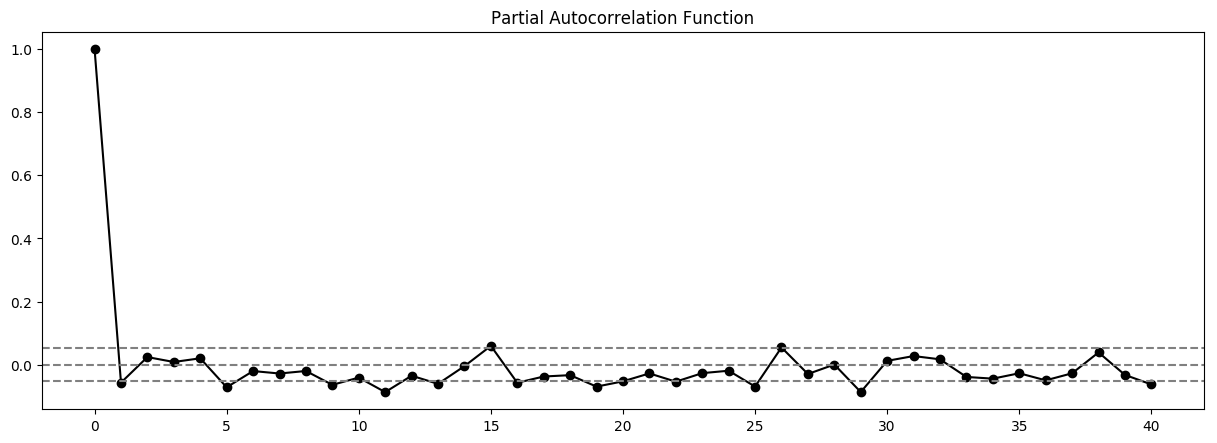

In [148]:
lag_pacf = pacf(prcp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=2__

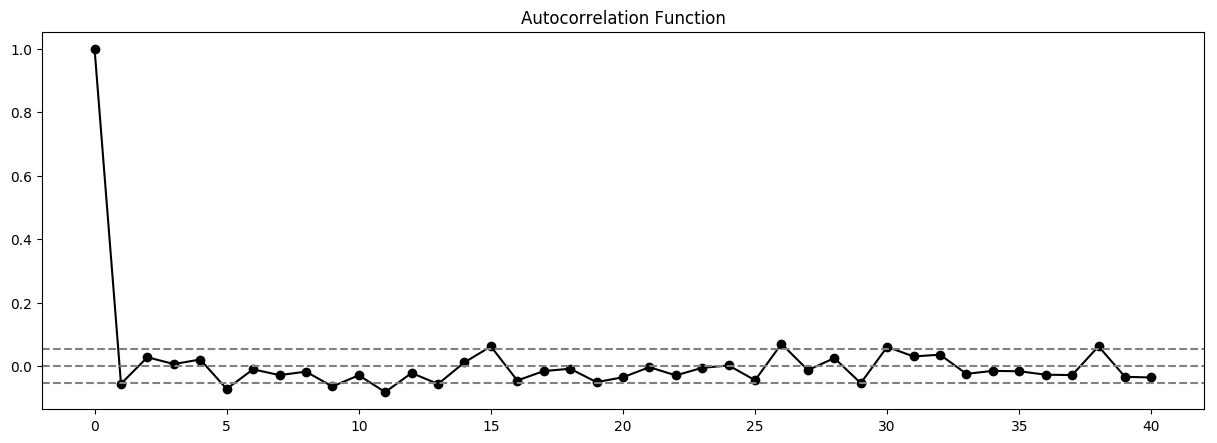

In [149]:
lag_acf = acf(prcp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=2__

Here, we should take p=0 and q=0, but then model predicts just straight line. Taking 2 as parameters yields in much more realistic prediction

__Fitting model and predicting__

In [154]:
prcp_model = ARIMA(prcp_res, order=(2, 0, 2))
prcp_model_fit = prcp_model.fit(disp=-1)

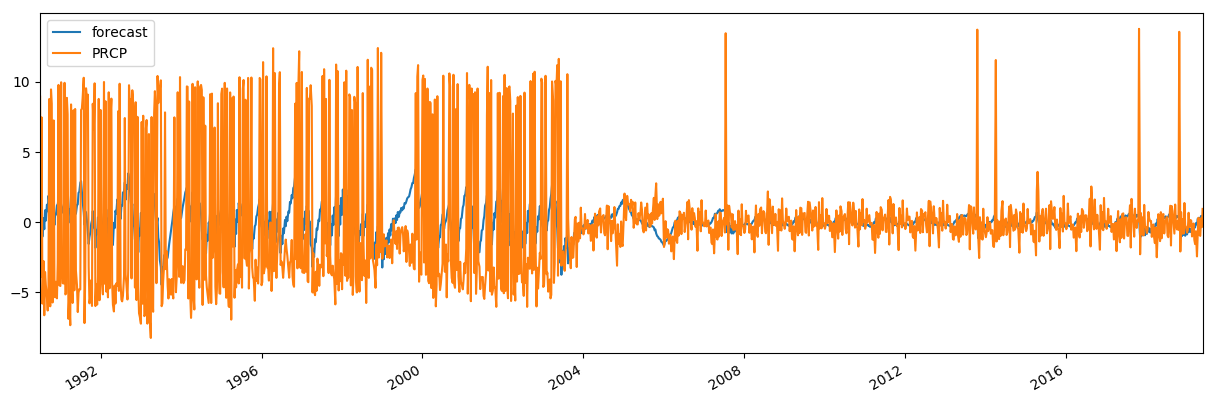

In [155]:
# Actual vs Fitted
prcp_model_fit.plot_predict(dynamic=False)
plt.show()

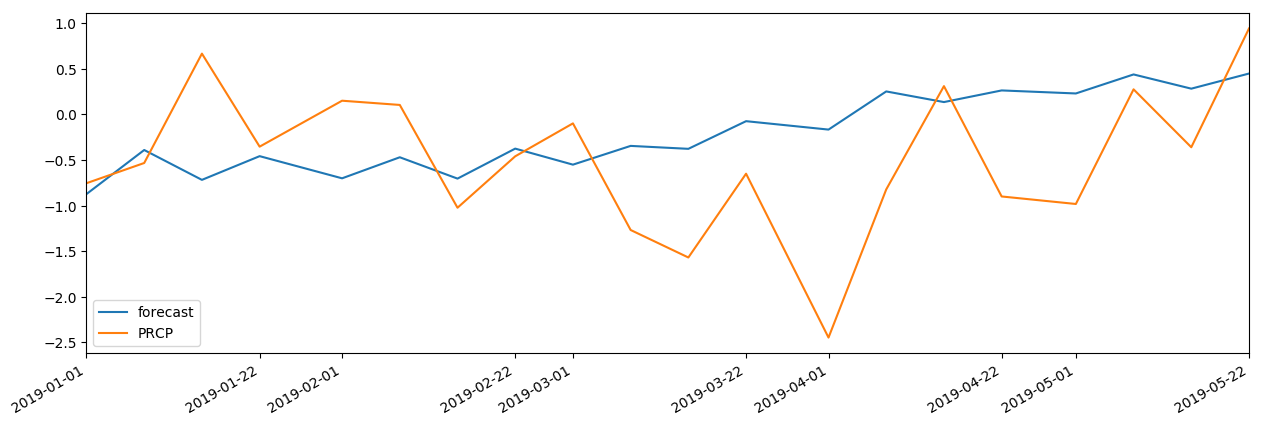

In [156]:
# only 2019 year
prcp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()